# Problem
In the capacitated p-median problem there is a set of demand locations (customers) and a set of facility sites (medians). We have to select locations for p-facilities and select for every facility a disjunct subset of customers together with the facility so that the sum of service demands of customers do not exceed the service capacity of their facility and every customer belongs to exactly one facility. The aim is to minimize the total transportation costs while satisfying the demands of the customers from the facilities

## SPEA Algorithm

## NSGA2 Algorithm
1. Initialize a random population.
2. Evaluate parents in a tournament selection by rank and crowding distance. (lexicographic order)
3. Select best parents for reproduction.
4. Create offspring population. (selection, crossover and mutation)
5. Evaluate offspring by rank and crowding distance.
6. Create new parents from best frontiers.

### Questions
- When we evaluate parents by rank, what does that mean? Is the rank the same as the frontier?
- Should we implement logic so that a facility cannot have the same coordinates as a customer?

In [53]:
from dataclasses import dataclass
import random
import math
import matplotlib.pyplot as plt

In [54]:
@dataclass
class Customer:
    id: int
    x: float
    y: float
    demand: int

class Facility:
    customers: list[Customer]

    def __init__(self, x, y, capacity) -> None:
        self.x = x
        self.y = y
        self.capacity = capacity
        self.customers = []
    
    def add_customer(self, customer):
        self.customers.append(customer)

    def get_remaining_resources(self):
        used_resources = sum(c.demand for c in self.customers)
        return self.capacity - used_resources
    
    def __repr__(self) -> str:
        return f"{self.x} {self.y}: {len(self.customers)}"

class Solution:
    def __init__(self, service_distance_score, facility_dispersion_score, facilities: list[Facility]) -> None:
        self.service_distance_score = service_distance_score
        self.facility_dispersion_score = facility_dispersion_score
        self.facilities = facilities
        self.dominates: list[Solution] = []
        self.dominated_by_count = 0

In [55]:
def parse_p_median(file, target_id):
    current_id = -1
    current_best_value = -1
    with open(file,"r") as f:
        lines = [line.strip() for line in f if line.strip()]
    for i in range(len(lines)):
        parts=lines[i].split()
        if len(parts) == 2:
            current_id=int(parts[0])
            current_best_value=int(parts[1])
        if current_id == target_id:
            constraints=lines[i+1].split()
            number_of_customers=int(constraints[0])
            number_of_medians=int(constraints[1])
            capacity_of_medians=int(constraints[2])
            customers=[]
            for j in range(i+2,i+2+number_of_customers):
                each_line=lines[j].split()
                customers.append({
                    "id": int(each_line[0]),
                    "x_coordinate":float(each_line[1]),
                    "y_coordinate":float(each_line[2]),
                    "demand":int(each_line[3])
                })
            return {
                "id": target_id,
                "best_known_value": current_best_value,
                "number_of_medians":number_of_medians,
                "capacity_of_medians":capacity_of_medians,
                "customers":customers
            }
    return dict()

### Calculate metrics for evaluation

In [56]:
def total_service_distance(facilities):
    total = 0.0
    for f in facilities:
        for c in f.customers:
            total += math.sqrt((f.x - c.x) ** 2 + (f.y - c.y) ** 2)
    return total

def total_facility_dispersion(facilities):
    total = 0.0
    n = len(facilities)
    for i in range(n):
        for j in range(i + 1, n):
            fi, fj = facilities[i], facilities[j]
            total += math.sqrt((fi.x - fj.x) ** 2 + (fi.y - fj.y) ** 2)
    return total

### Create parents
Each parent randomly selects p-facilities and assigns customers to the closest facility, given that the facility has enough capacity for the customer. 
We iterate through the customers randomly to make sure that the first customer in the list is not always guaranteed to be assigned to the closest facility.

In [57]:
def create_parents(num_parents, facility_count, facility_capacity, min_x, max_x, min_y, max_y, customers) -> list[list[Facility]]:
    parents = []
    for _ in range(num_parents):
        # randomly select facility coordinates
        facilities = list[Facility]()
        for _ in range(facility_count):
            x = random.uniform(min_x, max_x)
            y = random.uniform(min_y, max_y)
            f = Facility(x, y, facility_capacity)
            facilities.append(f)

        # assign each customer to the closest facility (if facility has enough resources)
        random.shuffle(customers)
        for c in customers:
            closest_facility_index = -1
            closest_facility_distance = math.inf
            for i, f in enumerate(facilities):
                distance = math.sqrt((f.x - c.x) ** 2 + (f.y - c.y) ** 2)
                if distance < closest_facility_distance and c.demand < f.get_remaining_resources():
                    closest_facility_index = i
                    closest_facility_distance = distance
            facilities[closest_facility_index].add_customer(c)
        parents.append(facilities)
    return parents

### Calculate fronts
Compare solutions with each other and assign them to fronts based on dominance relationships.

In [58]:
def calculate_fronts(solutions: list[Solution]):
    frontiers: list[list[Solution]] = []
    
    # populate dominance relationship 
    n = len(solutions)
    for i in range(n):
        for j in range(i + 1, n):
            if (solutions[i].service_distance_score <= solutions[j].service_distance_score and solutions[i].facility_dispersion_score >= solutions[j].facility_dispersion_score) and (solutions[i].service_distance_score < solutions[j].service_distance_score or solutions[i].facility_dispersion_score > solutions[j].facility_dispersion_score):
                solutions[i].dominates.append(solutions[j])
                solutions[j].dominated_by_count += 1
    
    # assign solutions to frontiers
    has_front = True
    while has_front:
        has_front = False
        current_front: list[Solution] = []
        # add all solutions that are not dominated
        for s in solutions:
            if s.dominated_by_count == 0:
                s.dominated_by_count = -1
                current_front.append(s)
        frontiers.append(current_front)

        # remove current front and calculate if there is a new front
        for f in current_front:
            for d in f.dominates:
                d.dominated_by_count -= 1
                has_front = has_front or d.dominated_by_count == 0
            f.dominates.clear()
    
    return frontiers
    

### Parse Dictionary output into objects

In [59]:
problem = parse_p_median("p_median_capacitated.txt",1)
best_known_value = problem["best_known_value"]
facility_count = problem["number_of_medians"]
facility_capacity = problem["capacity_of_medians"]

# get minimum and maximum coordinates
min_x, max_x, min_y, max_y = math.inf,0,math.inf,0
customers = list[Customer]()
for item in problem["customers"]:
    x, y = item["x_coordinate"], item["y_coordinate"]
    if x < min_x:
        min_x = x
    if x > max_x:
        max_x = x
    if y < min_y:
        min_y = y
    if y > max_y:
        max_y = y
    c = Customer(item["id"], x, y, item["demand"])
    customers.append(c)
customers

[Customer(id=1, x=2.0, y=62.0, demand=3),
 Customer(id=2, x=80.0, y=25.0, demand=14),
 Customer(id=3, x=36.0, y=88.0, demand=1),
 Customer(id=4, x=57.0, y=23.0, demand=14),
 Customer(id=5, x=33.0, y=17.0, demand=19),
 Customer(id=6, x=76.0, y=43.0, demand=2),
 Customer(id=7, x=77.0, y=85.0, demand=14),
 Customer(id=8, x=94.0, y=6.0, demand=6),
 Customer(id=9, x=89.0, y=11.0, demand=7),
 Customer(id=10, x=59.0, y=72.0, demand=6),
 Customer(id=11, x=39.0, y=82.0, demand=10),
 Customer(id=12, x=87.0, y=24.0, demand=18),
 Customer(id=13, x=44.0, y=76.0, demand=3),
 Customer(id=14, x=2.0, y=83.0, demand=6),
 Customer(id=15, x=19.0, y=43.0, demand=20),
 Customer(id=16, x=5.0, y=27.0, demand=4),
 Customer(id=17, x=58.0, y=72.0, demand=14),
 Customer(id=18, x=14.0, y=50.0, demand=11),
 Customer(id=19, x=43.0, y=18.0, demand=19),
 Customer(id=20, x=87.0, y=7.0, demand=15),
 Customer(id=21, x=11.0, y=56.0, demand=15),
 Customer(id=22, x=31.0, y=16.0, demand=4),
 Customer(id=23, x=51.0, y=94.0, d

In [60]:
solution_facilities = create_parents(5, facility_count, facility_capacity, min_x, max_x, min_y, max_y, customers)
solutions = list[Solution]()
for facilities in solution_facilities:
    dispersion_score = total_facility_dispersion(facilities)
    service_score = total_service_distance(facilities)
    solution = Solution(service_score, dispersion_score, facilities)
    solutions.append(solution)
fronts = calculate_fronts(solutions)
print(fronts)

[[<__main__.Solution object at 0x127b1d940>, <__main__.Solution object at 0x127d77250>, <__main__.Solution object at 0x1270be2c0>], [<__main__.Solution object at 0x127d77390>, <__main__.Solution object at 0x1270be780>]]


### Visualize fronts

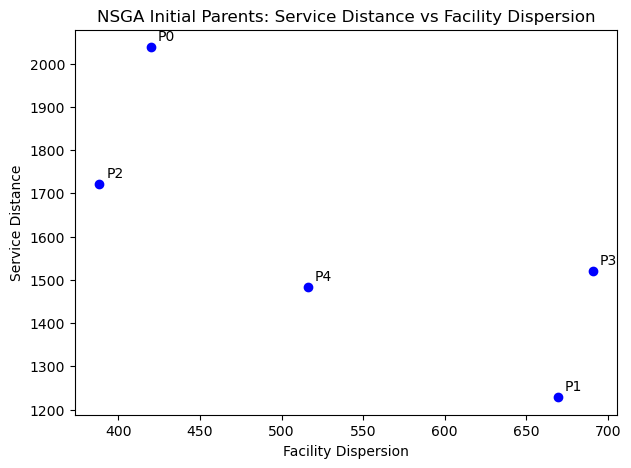

In [61]:
x_dispersion = []
y_service_distance = []

for solution in solutions:
    x_dispersion.append(solution.facility_dispersion_score)
    y_service_distance.append(solution.service_distance_score)

plt.figure(figsize=(7, 5))
plt.scatter(x_dispersion, y_service_distance, color="blue")

for i, (x, y) in enumerate(zip(x_dispersion, y_service_distance)):
    plt.annotate(f"P{i}", (x, y), xytext=(5, 5), textcoords="offset points")

plt.xlabel("Facility Dispersion")
plt.ylabel("Service Distance")
plt.title("NSGA Initial Parents: Service Distance vs Facility Dispersion")
plt.show()

### Visualize facility placements

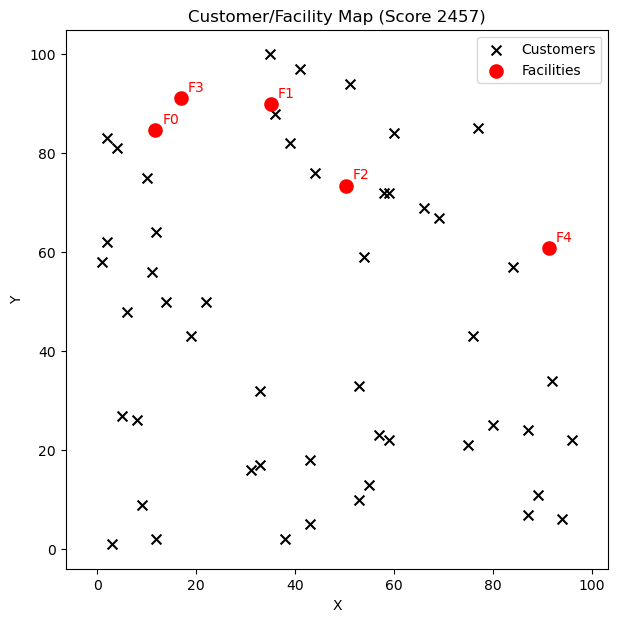

In [62]:
solution = solutions[0]

plt.figure(figsize=(7, 7))

# plot customers
cx = [c.x for c in customers]
cy = [c.y for c in customers]
plt.scatter(cx, cy, marker="x", color="black", s=50, label="Customers")

# plot facilities
fx = [f.x for f in solution.facilities]
fy = [f.y for f in solution.facilities]
plt.scatter(fx, fy, marker="o", color="red", s=90, label="Facilities")

# annotate facilities
for i, f in enumerate(solution.facilities):
    plt.annotate(f"F{i}", (f.x, f.y), xytext=(5, 5), textcoords="offset points", color="red")

score = solution.service_distance_score + solution.facility_dispersion_score

plt.xlabel("X")
plt.ylabel("Y")
plt.title(f"Customer/Facility Map (Score {int(score)})")
plt.legend()
plt.axis("equal")
plt.show()